# LGU+ 경진대회 - 베이스라인  
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
- 구현된 모델의 검증 데이터셋과 리더보드의 성능을 확인

## 목차 
- 데이터 전처리 
    - 기본 설정
    - 데이터 불러오기 
    - 학습 및 검증 데이터 생성 
- NeuMF 구현    
    - 모델 구현 
    - 학습 및 추론 코드 구현
- 모델 학습 
    - 하이퍼 파라미터 설정 & 최적화 기법 설정
    - 모델 학습 
    - 학습 과정 시각화 
- 제출 
    - 모든 유저에 대해 추천 결과 생성
    - 저장 

## 데이터 전처리
### 기본 설정

In [441]:
# 검색용 : forsearch
# 1. 패키지 로드 : package (# 패키지 로드)
# 2. cfg : 클래스cfg (# cfg 하이퍼 파라미터)
# 3. seed_everything : fixseed (# 시드 고정)
# 4. 경로 : localpath (# 경로 설정)
# 5. 불러온 데이터 : originaldata (# 데이터 불러오기)
# 6. 중복제거 후 rating열 추가 : dropduplicate (# 데이터 전처리 (중복제거))
# 7. train_test_split : traintestsplist (# 학습 및 검증 데이터 분리)
# 8. matrix를 만들고 그걸 rating에 대응 : makematrix (# Matrix 형태로 변환)
# 9. profile_id 대응 나이 추출 : userfeaturesextraction (# 유저 특징 정보 추출)
# 10. album_id 대응 장르 mid 추출 : itemfeaturesextraction (# 아이템 특징 정보 추출)
# 11. genre_mid 속성과 continues_feats 저장 : savegenremidnunique (# 추출한 특징 정보의 속성을 저장)
# 12. 모델 구현 : modeling (# 모델 구현)
# 13. dateset을 만듬 : makeUIdateset (# 학습 및 추론 코드 구현)
# 14. UIdataset을 만듬 : realmakeUIdataset
# 15. batchdata를 만듬 : makebatchdata
# 16. 여기서 학습을 시키는 것 같음 : Learningandverification
# 17. 검증, 평가 : Learningandverification2
# 18. 뭘까 여긴 : Learningandverification3
# 19. 하이퍼 파라미터 설정 : 하이퍼파라미터
# 20. model 생성 및 optimizer, loss 함수 설정  : settingmodeloptimizerloss

In [442]:
# pip install plotnine

In [443]:
# pip uninstall lxml -y

In [444]:
# pip install lxml

In [9]:
# 1
# 패키지 로드
# package
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [446]:
# 2
# 하이퍼 파라미터 
# 클래스cfg
class cfg:
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [447]:
# 3
# 시드 고정 
# fixseed
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [448]:
# 4
# 경로 설정
# localpath
data_path = '../data'
saved_path = './saved'
output_path = './submission'

In [449]:
# # 경로 설정
# data_path = 'E:\\aivle\\2022_uplus_ai_ground\\data'
# saved_path = 'E:\\aivle\\2022_uplus_ai_ground\\data\\saved'
# output_path = 'E:\\aivle\\2022_uplus_ai_ground\\data\\submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

In [450]:
# 5
# 데이터 불러오기 
# originaldata
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')


In [451]:
watch_test1 = watch_df.loc[:, ['album_id', 'profile_id']]
his_test1 = history_df.loc[:, ['album_id', 'profile_id']]
# display(watch_test1[watch_test1['profile_id'] == 3].head())
# display(his_test1[his_test1['profile_id'] == 3].head())
du_watch = watch_test1.drop_duplicates('profile_id')
du_his = his_test1.drop_duplicates('profile_id')
print('--'*30)
result1 = pd.concat([du_watch,du_his])
result2 = result1.drop_duplicates(['profile_id'], keep = False)
display(result2)

for i in range (653):
    print(result2.iloc[:, i])
    break
result3 = pd.concat([watch_e_data,result2])
result3 = result3.fillna(0)

# display(result3)
# result3.to_csv('watch_e_data_add_profile.csv')

------------------------------------------------------------


,album_id,profile_id
573,352,12
3472,2159,74
6085,16,136
11337,190,293
11370,625,300
...,...,...
999059,802,32627
999289,178,32647
999350,3326,32650
1005252,4027,32979


573         352
3472       2159
6085         16
11337       190
11370       625
           ... 
999059      802
999289      178
999350     3326
1005252    4027
1005480    1005
Name: album_id, Length: 653, dtype: int64


NameError: name 'watch_e_data' is not defined

In [452]:
# base_df = pd.DataFrame()
# for i in range (result2.shape[0]):
#     a = result2.iloc[i, 1]
#     if a in list(history_df['profile_id']):
#         base_df = pd.concat([base_df,history_df[history_df['profile_id'] == a]])
# display(base_df)

In [453]:
watch_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')

watch_for_con = pd.read_csv(os.path.join(data_path, 'his_profile_id_not_in_watch.csv'), encoding='utf-8')
watch_for_con1 = watch_for_con.loc[:, ['album_id', 'profile_id', 'log_time']]
watch_df = pd.concat([watch_df, watch_for_con1])
watch_df = watch_df.fillna(0)
watch_df

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,2.022030e+13,20220301115805,MKID049,15,46.0,46.0,1.0
1,3,2.022030e+13,20220301115954,MKID049,16,104.0,105.0,1.0
2,3,2.022030e+13,20220301120114,MKID049,17,76.0,76.0,1.0
3,3,2.022030e+13,20220301120226,MKID049,18,67.0,68.0,1.0
4,3,2.022030e+13,20220301120400,MKID049,19,90.0,90.0,0.0
...,...,...,...,...,...,...,...,...
16706,32979,0.000000e+00,20220424101309,0,667,0.0,0.0,0.0
16707,32979,0.000000e+00,20220424101612,0,5191,0.0,0.0,0.0
16708,32979,0.000000e+00,20220424101621,0,5191,0.0,0.0,0.0
16709,33022,0.000000e+00,20220424110250,0,1005,0.0,0.0,0.0


### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [454]:
# 6
# 데이터 전처리 (중복제거) 
# dropduplicate
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = watch_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
display(data)
cfg.n_users = data.profile_id.max()+1 # cfg n_users에 profile_id 최댓값+1 값을 유저수로 추가
cfg.n_items = data.album_id.max()+1 # item 개수는 album_id 최댓값+1

,profile_id,log_time,album_id,rating
0,3,20220301115805,15,1
1,3,20220301115954,16,1
2,3,20220301120114,17,1
3,3,20220301120226,18,1
4,3,20220301120400,19,1
...,...,...,...,...
815868,33032,20220427155653,381,1
815869,33032,20220427155694,381,1
815870,33032,20220427155826,125,1
815871,33032,20220427155836,125,1


In [455]:
# 7
# 학습 및 검증 데이터 분리
# traintestsplist
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
) # test_size = 0.2, seed = 42
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (652698, 4)
검증 데이터 크기: (163175, 4)


In [456]:
# 8
# Matrix 형태로 변환 
# makematrix
train = train.to_numpy() # train data를 넘파이 형태로 변환
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items)) # lil_matrix((M, N), [dtype]) : dtype은 선택, 모양이 m, n인 **빈 행렬** 구성
'''
2. PreliminariesPermalink의
    Learning from implicit data
    
    -- 여기서의 0은 비선호를 의미하지는 않음, 해당 아이템을 모를때에도 0으로 표기됨
'''
for (p, _, i, r) in tqdm(train): # p = profile_id 첫번째 행, i = album_id 첫번째 행, r = rating 첫번째 행
    matrix[p, i] = r # 여기가 이해가 안됨 ㅠㅠ <-- 그냥 값을 뽑아서 매트릭스를 만들고 그 값을 1에 대응시키는거 같음
train = sparse.csr_matrix(matrix) # 매트릭스를 다시 희소 행렬로 변환 --> 0을 제외한 데이터를 저장한다, 
print('---'*30)
train = train.toarray() # 다시 array로 변환
print("train 형태: \n", train)

  0%|          | 0/652698 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------
train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [457]:
# 9
# 유저 특징 정보 추출 
# userfeaturesextraction
from itertools import islice

profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

profile_df = profile_df.set_index('profile_id') # profile_id를 인덱스로 지정
user_features = profile_df[['age']].to_dict() # profile_df의 age를 dictionary로 변형
print("user_id 3의 age 정보 :", user_features['age'][3]) # user_id와 age를 엮어주는거 같음, 
# user_features라는 딕셔너리 안의 key값은 age, age키의 값이 profile_id를 key로 가지고 나이를 값으로 가지는 딕셔너리가 됨 (user_features는 이중 딕셔너리)

dict(islice(user_features['age'].items(), 5)) # 딕셔너리 인덱스 5까지 출력

user_id 3의 age 정보 : 5


{3: 5, 5: 5, 7: 9, 12: 6, 16: 12}

In [458]:
# 10
# 아이템 특징 정보 추출 
# itemfeaturesextraction
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')

meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [459]:
# 추가한거

le = LabelEncoder()
profile_df['sex'] = le.fit_transform(profile_df['sex'])

user_features2 = profile_df[['sex']].to_dict() # profile_df의 age를 dictionary로 변형
print("user_id 3의 sex 정보 :", user_features2['sex'][3]) # user_id와 age를 엮어주는거 같음, 
# user_features라는 딕셔너리 안의 key값은 age, age키의 값이 profile_id를 key로 가지고 나이를 값으로 가지는 딕셔너리가 됨 (user_features는 이중 딕셔너리)

dict(islice(user_features2['sex'].items(), 5)) # 딕셔너리 인덱스 5까지 출력

user_id 3의 sex 정보 : 0


{3: 0, 5: 1, 7: 0, 12: 1, 16: 0}

In [460]:
# 11
# 추출한 특징 정보의 속성을 저장
# savegenremidnunique
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = profile_df['sex'].nunique()
cfg.n_continuous_feats = 1 

In [461]:
# 13번 셀 positive, negative 참고 (ReferencePN)
# 
count = 0 # 3번 5번 이렇게 profile_id 데이터 값이 있어서 얘네만 나오는거 같음

for user_id, items_by_user in enumerate(train):
    print(count)
    pos_item_ids = np.where(items_by_user > 0.5)[0]
    num_pos_samples = len(pos_item_ids)
    print(len(pos_item_ids))
    num_neg_samples = cfg.neg_ratio * num_pos_samples
    neg_items = np.where(items_by_user < 0.5)[0]
    print(len(neg_items))
    print('--'*30)
    count += 1
    if count > 1:
        break

0
0
25917
------------------------------------------------------------
1
0
25917
------------------------------------------------------------


## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [462]:
# 12
# modeling

class NeuMF(nn.Module): # 파이토치 모델링의 기본 골자 (https://anweh.tistory.com/21)
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg): # 초기화 함수
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        # __init()__에서는 모델에서 사용될 module(nn.Linear, nn.Conv2d), activation function(nn.functional.relu, nn.functional.sigmoid)등을 정의한다. 
        # 여기서는 모델명 = NeuMF
        
# n_users = data.profile_id.max()+1, 
# n_items = data.album_id.max()+1
# emb_dim = 256
# layer_dim = 256
# n_continuous_feats = 1
# n_genres = meta_df['genre_mid'].nunique() = 29, //2하면 14
# dropout = 0.05
        
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex # 추가한거
        self.dropout = cfg.dropout
        self.build_graph() # forward 이전 input 코딩이 너무 크므로 함수 build_graph로 대체하여 집어넣은 것 같음

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # nn.Embedding 참고 (https://wikidocs.net/64779)
        ''' 
        num_embeddings : 임베딩을 할 단어들의 개수. 다시 말해 단어 집합의 크기입니다. <--
        embedding_dim : 임베딩 할 벡터의 차원입니다. 사용자가 정해주는 하이퍼 파라미터입니다. <--
        padding_idx : 선택적으로 사용하는 인자입니다. 패딩을 위한 토큰의 인덱스를 알려줍니다.
        '''
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim) # n_users = data.profile_id.max()+1, emb_dim = 256
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        # ex) embedding_dim이 3, num_embeddings=8이면 // num_embeddings 행 개수, embedding_dim이 열 개수
        
        # tensor([[-0.1778, -1.9974, -1.2478],
        # [ 0.0000,  0.0000,  0.0000],
        # [ 1.0921,  0.0416, -0.7896],
        # [ 0.0960, -0.6029,  0.3721],
        # [ 0.2780, -0.4300, -1.9770],
        # [ 0.0727,  0.5782, -3.2617],
        # [-0.0173, -0.7092,  0.9121],
        # [-0.4817, -1.1222,  2.2774]], requires_grad=True)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim) # 여기까지 4줄은 다 똑같음
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2) # 장르 임베딩 하이퍼 파라미터는 n_genres = meta_df['genre_mid'].nunique()
                                                                                                        # 임베딩 차원이 장르/2라는 특이한 점이 있음
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex//2) # 추가한거   

        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_sex//2 + self.n_continuous_feats, self.layer_dim), # (https://m.blog.naver.com/fbfbf1/222480437930)
            # 추가한거
            # nn.Linear의 형태는 nn.Linear(input_dim,output_dim)이다
            # 여기서 input은 256*2 + 29//2 + 1, output은 256
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), # dropout = 0.05
            nn.Linear(self.layer_dim, self.layer_dim//2), # layer_dim = 256
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1) # affine output 밑에 나올지도 모름, input --> 256//2 + 256, output --> 1
        self.apply(self._init_weights) # _init_weights는 바로 아래 함수, 전체에 이 _init_weights를 적용함 <-- 가중치를 초기화하는 함수
        
    ################################################################################################################################
    # -------------> (https://wandb.ai/wandb_fc/korean/reports/PyTorch-Weight---VmlldzoyNDc4NjYx) <------------- 여기 답이 나와있었음#
    ################################################################################################################################
    def _init_weights(self, module):
        '''
        torch.nn.init.normal_(tensor, mean=0.0, std=1.0)[SOURCE] (https://pytorch.org/docs/stable/nn.init.html)
            
            Fills the input Tensor with values drawn from the normal distribution \mathcal{N}(\text{mean}, \text{std}^2)N(mean,std 
            (translate : 정규분포에서 가져온 값으로 입력 Tensor를 채웁니다)
                
        Parameters:
            tensor (Tensor) an n-dimensional torch.Tensor (Tensor의 차원)
            mean (float) the mean of the normal distribution (정규분포의 평균)
            std (float) the standard deviation of the normal distribution (정규분포의 표준편차)
        '''
        if isinstance(module, nn.Embedding): # isinstance(확인하고자 하는 데이터 값, 확인하고자 하는 데이터 타입)
            normal_(module.weight.data, mean=0.0, std=0.01)
            # 같으면 True, 다르면 False 반환
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats): # forward()에서는 모델에서 실행되어야하는 계산을 정의한다
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices) # line 49
        item_embedding_mf = self.item_embedding_mf(item_indices) # line 50
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf) # mul = 곱, tensor로 출력
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices) # line 62
        item_embedding_mlp = self.item_embedding_mlp(item_indices) # line 63
        genre_embedding_mlp = self.genre_embeddig(feats[1]) # feats[1]은 아래 16번 셀의 24번 줄에서 나옴, feats로 들어오는 리스트의 1번째 인덱스 값을 넣는다는 뜻
        sex_embedding_mlp = self.sex_embeddig(feats[2].long()) # 추가한거
        
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, sex_embedding_mlp, feats[0].unsqueeze(1)), -1) # 추가한거
        # torch.cat = 주어진 차원에서 주어진 텐서 시퀀스를 연결 합니다. 모든 텐서는 모양이 같거나(연결 차원 제외) 비어 있어야 합니다. <-- 그냥 concat인듯
        
        # unsqueeze는 차원을 생성해주는 함수, 1 이니 1 인덱스에 생성될 것임 (ex) x.unsqueeze(dim=1) #[3, 20, 128] -> [3, 1, 20, 128]) 
        input_feature = torch.tensor(input_feature).to(cfg.device).float()
        mlp_output = self.mlp_layers(input_feature) # mlp_layers = 아까 쌓았던 Linear, Relu 이거 모델
        # 모델에 input으로 mlp들과 feats[0]을 곱한걸 넣어줌 = 그게 mlp_output
        
        output = torch.cat([mlp_output, mf_output], dim=-1) # (https://beausty23.tistory.com/159) 가장 높은차원부터면 오름차순, 가장 낮은차원부터는 내림차순
        # dim = -1은 가장 낮은 차원에서 + 1, 1차원이 가장 낮을테니 아마 2차원
        # mf는 profile, album임, mlp도 아마 그런거같음 <-- 이미지 참고
        
        output = self.affine_output(output).squeeze(-1) # line 76
        # 가장 낮은 차원에서 하나 위, 아마 2차원 삭제
        # 해석해보면 리니어 층을 통과 시킨 뒤 차원 하나 삭제?
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [463]:
# 13
# makeUIdateset

def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율, negative sampling은 전체 데이터를 활용하는게 아니라 중심 데이터와 상관없는 것 중 몇개만 추출하여 사용, 
                                                아마 주변 데이터를 활용하는건 반대로 positive 같음
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train): # user_id = 인덱스, items_by_user = 인덱스에 해당하는 데이터, 참고 검색 --> ReferencePN
        UIdataset[user_id] = [] # UIdataset의 user_id들에게 리스트 할당
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0] # items_by_user에서 0.5 초과인 값의 profile_id 추적 --> list형태로 나옴
        num_pos_samples = len(pos_item_ids) # 0.5이상인 전체 값의 개수

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples # neg_ratio = negative sampling 활용을 얼마나 할지 결정하지 위해 곱해줌
        neg_items = np.where(items_by_user < 0.5)[0] # 얘는 미만 --> 상당히 수가 많이 나옴
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False) # net_ratio로 일부만 사용된 negative sample에서 랜덤하게 추출해서 사용
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids])) # positive sample과 negative sample을 concat해서 UIdataset[user_id]에 넣어줌
        
        # feature 추출 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): # positive, negative 두개를 concat한걸 item_id에 넣어서 append하는거 같은데...
            features.append(user_features['age'][user_id]) # 여기에는 이상한게 item_id가 없음, 오타거나 안쓰거나 --> 아마 안쓰는거같음, 전체 for문에서 user_id (0, 1, 2, 3...)을 받아옴
            # user_features = profile_df[['age']].to_dict()
        UIdataset[user_id].append(np.array(features)) # 값들을 넣은 features를 array로 변경 후 user_id에 append
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): # 위와 마찬가지
            features.append(item_features['genre_mid'][item_id]) # 여기서는 item_id를 씀, 위에서 추적한 (line 32, 37) profile_id들의 위치를 features로 사용함
        UIdataset[user_id].append(np.array(features)) # 값들을 넣은 features를 array로 변경 후 user_id에 append
        
        features = [] # 추가한거
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): # 위와 마찬가지
            features.append(user_features2['sex'][user_id]) # 여기서는 item_id를 씀, 위에서 추적한 (line 32, 37) profile_id들의 위치를 features로 사용함
        UIdataset[user_id].append(np.array(features)) # 값들을 넣은 features를 array로 변경 후 user_id에 append
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids)) # positive 길이 만큼 1로 가득찬 array 생성
        neg_labels = np.zeros(len(neg_item_ids)) # negative 길이 만큼 0으로 가득찬 array 생성
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels])) # 라벨들을 concat해서 user_id에 append

        # 그럼 UIdataset[user_id]에는 
        # positive, negative를 concat한 값
        # 값들을 넣은 features들을 array로 변경한 값
        # positive, negative길이 만큼의 0, 1이 들어간 값
        # 이 4개가 들어감 (feature가 2개기 때문)
    return UIdataset

In [464]:
# 14
# realmakeUIdataset
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio) # neg_ratio = 100

In [465]:
# 15
# makebatchdata
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size] # 안 건드려도 될거 같음
    batch_user_ids = [] # 위 return 참고
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = [] # 추가한거
    batch_labels = []
    for user_id in batch_user_indices: # batch_user_indices에 넣은 값들을 user_id로 하나씩 뽑음
        item_ids = UIdataset[user_id][0] # positive, negative를 concat한 값, 13번 셀 (makeUIdateset) line 58 ~62 참고
        feat0 = UIdataset[user_id][1] # 값들을 넣은 features1을 array로 변경한 값
        feat1 = UIdataset[user_id][2] # 값들을 넣은 features2을 array로 변경한 값
        feat2 = UIdataset[user_id][3] # 추가한거
        labels = UIdataset[user_id][4] # positive, negative길이 만큼의 0, 1이 들어간 값 # 추가한거 (정확히는 변경된값임)
        user_ids = np.full(len(item_ids), user_id) # full은 item_ids의 길이만한 array의 모든 값을 user_id로 채워줌
        batch_user_ids.extend(user_ids.tolist()) # array를 list로 바꿔줌
        batch_item_ids.extend(item_ids.tolist()) # array를 list로 바꿔줌
        batch_feat0.extend(feat0.tolist()) # array를 list로 바꿔줌
        batch_feat1.extend(feat1.tolist()) # array를 list로 바꿔줌
        batch_feat2.extend(feat2.tolist()) # 추가한거
        batch_labels.extend(labels.tolist()) # array를 list로 바꿔줌
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_labels

def update_avg(curr_avg, val, idx): # 안 건드려도 될거 같음
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [466]:
# 16
# Learningandverification
def train_epoch(cfg, model, optimizer, criterion): 
    model.train() # train mode로 변경해 줌 (https://rabo0313.tistory.com/entry/Pytorch-modeltrain-modeleval-%EC%9D%98%EB%AF%B8)
    curr_loss_avg = 0.0 # 안 건드려도 될거 같음

    user_indices = np.arange(cfg.n_users) # n_users(data.profile_id.max()+1)만큼의 요소를 가진 array 생성 (ex) np.arange(10) --> array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
    np.random.RandomState(cfg.epoch).shuffle(user_indices) # cfg.epoch = 25, 지정해준 epoch값을 seed로 두고 user_indices를 섞어줌
    # (https://frhyme.github.io/python-libs/np_random_randomstate/), (https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.shuffle.html)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1 # batch_size = 256
    # user_indices의 길이 --> 대략 33000, 이걸 256으로 나눈 것을 정수화 + 1
    bar = tqdm(range(batch_num), leave=False) # leave는 한줄로 출력시킬지 말지 정하는 것 (True = 한줄), tqdm을 왜 쓴걸까 <-- enumerate(tqdm)를 그냥 같이 씀
    for step, batch_idx in enumerate(bar): # 프로그레스 바를 표현하는 방식이 enumerate(tqdm), (https://studyforus.com/tipnknowhow/701850)
        user_ids, item_ids, feat0, feat1, feat2, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size) # 15번 셀 (makebatchdata) line 3
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device) # 64비트의 부호 있는 정수는 torch.LongTensor를 사용, torch.to는 특정 device에 적당한 Tensor를 return해줌
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device) # 추가한거
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1) # labels이라는 tensor를 2차원 (? X 1) 크기로 변경

        # grad 초기화
        optimizer.zero_grad() # (https://velog.io/@kjb0531/zerograd%EC%9D%98-%EC%9D%B4%ED%95%B4)

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2]) # 12번 셀 (modeling) line 104 # 추가한거
        output = output.view(-1, 1) # output tensor를 2차원 (? X 1) 크기로 변경

        loss = criterion(output, labels) # output과 labels의 loss 측정?
        # criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
        # 역전파
        loss.backward() # (https://wikidocs.net/37406) '순전파가 입력층에서 출력층으로 향한다면 역전파는 반대로 출력층에서 입력층 방향으로 계산하면서 가중치를 업데이트해갑니다'

        # 최적화
        optimizer.step() # (https://tutorials.pytorch.kr/beginner/basics/optimization_tutorial.html)
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step) # 15번 셀 (makebatchdata) line 43
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg) # 그냥 message 보여주는 것 같음
    rets = {'losses': np.around(curr_loss_avg.item(), 5)} # around = 주어진 소수 자리수로 고르게 반올림 함
# item함수 참고 --> dictionary에서 키값을 뽑아서 묶어서 반환해줌
# car = {"name" : "BMW", "price" : "7000"} 
# car.items() 
# dict_items([('name', 'BMW'), ('price', '7000')])

    return rets # losses계산식 (curr_loss_avg)에 넣어서 계산 후 반환

In [467]:
# 17
# Learningandverification2
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=25 상위 25개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual) # set이라는 타입의 집합으로 변함, 중복이 제거됨
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual)) # set 집합을 이용해 recall값을 구함, 안 건드려도 될거 같음
    return recall_k

def unique(sequence):
    # preserves order
    seen = set() # set하나 선언
    return [x for x in sequence if not (x in seen or seen.add(x))]
    # for x in sequence <-- sequence에서 값을 뽑아서 x에 넣어줌
        # if not (x in seen or seen.add(x)) <-- 중복을 제거해서 넣음? 이해가 잘 안됨
            # x # sequence에서 값을 뽑아서 seen에 넣고 x를 리스트에 넣어서 리턴해주는거 같은데, 해석 필요

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    # for i in range(min(k, len(set_actual)))
        # sum([1.0 / np.log(i + 2)]) <-- np.log는 자연로그를 취해줌
    dcg = 0.0
    unique_predicted = unique(predicted[:k]) # k번째까지의 특징 추출
    for i, r in enumerate(unique_predicted): # 
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2) # 진짜로 본거면 이걸 취해줌
    ndcg_k = dcg / idcg # enumerate해서 로그 취해준걸, 아까 sum에 로그 취했던걸로 나눠줌
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index() # gt의 profile_id별 album_id의 특징(unique)을 뽑고 그 시리즈를 데이터프레임으로 변환(to_frame)
                                                                                # 마지막으로 reset_index
    gt.columns = ['profile_id', 'actual_list'] # gt의 column명 변경, id와 실제로 본 상품의 리스트가 들어있는 것 같음

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id') # 예측값 기준 (profile_id 기준)으로 예측값과 gt를 merge
# 여긴 잘 모르겠음ㅠㅠ
    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1) # recallk는 line 3에 있음
    # ['Recall@25'] 여따 오른쪽껄 삽입
    # evaluated_data 여기 전체에 apply로 lambda 함수를 적용 --> lambda 함수는 recallk 함수를 갖고와서 사용
    # lambda 함수의 input으로 들어간 x에서 실제 시청 값과 예측 값을 뽑아서 --> recallk에 넣고 (axis=1은 아마 열을 나타내는거 같음 (actual, predicted)) 밖으로 보내줌
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean() # ndcg 설명 --> (https://joyae.github.io/2020-09-02-nDCG/)
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()
    # explode 사용 (https://wikidocs.net/158541)
    # top_k = 25, line 50의 데이터에 25번째까지 explode, nunique 적용 후 반환 후 meta_df의 인덱스 nunique로 나눠줌 <-- 이게 coverage
    score = 0.75*recall + 0.25*ndcg # 여기부턴 그냥 보여주는거 같음
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [468]:
# 18
# Learningandverification3
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval() # eval <-- 매개변수로 받은 값을 실행하는 함수
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids] # full_item_ids_feat1에 추론할 item array에서 추출한 값을 item_features['genre_mid'][c]
                                                                                 # c번째에 넣어서 반환
    # full_item_ids2 = np.array([d for d in range(cfg.n_users)]) # 추론할 모든 item array 집합 # 추가한거
    # full_item_ids_feat2 = [user_features2['sex'][d] for d in full_item_ids2]
    
    for user_id in query_user_ids:
        with torch.no_grad(): # (https://coffeedjimmy.github.io/pytorch/2019/11/05/pytorch_nograd_vs_train_eval/)
            user_ids = np.full(cfg.n_items, user_id) # full은 n_itmes의 길이만한 array의 모든 값을 user_id로 채워줌
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device) # 64비트의 부호 있는 정수는 torch.LongTensor를 사용, torch.to는 특정 device에 적당한 Tensor를 return해줌
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device) # 32-bit floating point는 torch.FloatTensor를 사용, torch.to는 특정 device에 적당한 Tensor를 return해줌
                                                            # 아마 age는 숫자에 데이터가 들어있는 수치형 변수라서 이걸 쓴 것 같음, 정확하진 않음
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            # feat2 = torch.LongTensor(full_item_ids_feat2).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features2['sex'][user_id]) # 추가한거
            feat2 = torch.FloatTensor(feat2).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2]).detach().cpu().numpy() # 추가한거
            # detach는 tensor를 복사 (원본이 변하면 같이 변함)
            # (https://byeongjo-kim.tistory.com/32)
            pred_u_score = eval_output.reshape(-1) #  = x.reshape(1, -1), 1차원 배열을 반환
        
        pred_u_idx = np.argsort(pred_u_score)[::-1] # argsort : 어레이 정렬, [::-1] <-- 거꾸로 출력
        # https://itholic.github.io/python-reverse-string/
        pred_u = full_item_ids[pred_u_idx] # line 8 과 line 28
        pred_list.append(list(pred_u[:cfg.top_k])) # top_k = 25, 
        
    pred = pd.DataFrame() # pred를 만들어 줌
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred) # 17번 셀 (Learningandverification2) line 37
        return rets, pred
    return pred

## 모델 학습

### 하이퍼 파라미터 설정 & 최적화 기법 설정

In [469]:
# 19
# 하이퍼파라미터
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [470]:
# 20
# settingmodeloptimizerloss
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device) # NeuMF에 적용해서 특정 device에 적당한 Tensor를 return해줌
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
# 19번 셀 (하이퍼파라미터)에 있음
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
# (https://aimaster.tistory.com/84), (https://nuguziii.github.io/dev/dev-002/)

### 학습 진행

In [471]:
total_logs = defaultdict(list) # key 1을 list로 준 딕셔너리를 생성 (https://dongdongfather.tistory.com/69)
best_scores  = 0 
for epoch in range(cfg.epochs+1): # epoch = 25
    cfg.epoch = epoch # cfg.epoch에 for로 돌아가는 값을 넣음
    train_results = train_epoch(cfg, model, optimizer, criterion) # 16번 셀 (Learningandverification) line 3
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: # check_epoch = 1, 1번마다 성능 확인
        valid_results, _ = valid_epoch(cfg, model, valid) # 18번 셀 (Learningandverification3) line 3

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            } # 로그 출력

        # 검증 성능 확인 
        for key, value in logs.items(): # items --> dictionary 키값 쌍을 얻음 (item함수 참고 --> dictionary에서 키값을 뽑아서 묶어서 반환해줌)
            # 16번 셀 (Learningandverification) line 47
            total_logs[key].append(value) # total_logs <-- line 1, 여기 key번째에 value를 넣어줌

        if epoch == 0: # ???, epoch마다 보여주는거 같음 아마
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: # pth파일 저장, # 안 건드려도 될거 같음
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  27753.431640  0.054708  0.033839  0.000677  0.049491


  0%|          | 0/130 [00:00<?, ?it/s]

01  13063.077150  0.174230  0.138005  0.004138  0.165173


  0%|          | 0/130 [00:00<?, ?it/s]

02  9184.101560  0.228931  0.173666  0.018132  0.215115


  0%|          | 0/130 [00:00<?, ?it/s]

03  7831.508300  0.332456  0.240742  0.054044  0.309527


  0%|          | 0/130 [00:00<?, ?it/s]

04  6436.910640  0.398404  0.288004  0.097154  0.370804


  0%|          | 0/130 [00:00<?, ?it/s]

05  5068.209470  0.442875  0.317773  0.160652  0.411599


  0%|          | 0/130 [00:00<?, ?it/s]

06  3831.755130  0.465377  0.331780  0.219210  0.431978


  0%|          | 0/130 [00:00<?, ?it/s]

07  2857.448240  0.474969  0.336812  0.268013  0.440429


  0%|          | 0/130 [00:00<?, ?it/s]

08  2129.196530  0.480842  0.339199  0.310445  0.445431


  0%|          | 0/130 [00:00<?, ?it/s]

09  1559.392210  0.482932  0.340701  0.338558  0.447374


  0%|          | 0/130 [00:00<?, ?it/s]

10  1114.401860  0.485114  0.341665  0.358270  0.449252


  0%|          | 0/130 [00:00<?, ?it/s]

11  804.522340  0.485610  0.341488  0.365843  0.449580


  0%|          | 0/130 [00:00<?, ?it/s]

12  588.583190  0.486268  0.341826  0.370257  0.450157


  0%|          | 0/130 [00:00<?, ?it/s]

13  433.852260  0.485523  0.341167  0.371511  0.449434


  0%|          | 0/130 [00:00<?, ?it/s]

14  325.289890  0.486009  0.341406  0.373994  0.449858


  0%|          | 0/130 [00:00<?, ?it/s]

15  244.879990  0.485549  0.341344  0.372564  0.449498


  0%|          | 0/130 [00:00<?, ?it/s]

16  185.374570  0.485415  0.341131  0.374796  0.449344


  0%|          | 0/130 [00:00<?, ?it/s]

17  142.003810  0.485104  0.340860  0.373994  0.449043


  0%|          | 0/130 [00:00<?, ?it/s]

18  110.773630  0.485527  0.340771  0.375298  0.449338


  0%|          | 0/130 [00:00<?, ?it/s]

19  87.597830  0.485776  0.341011  0.375273  0.449585


  0%|          | 0/130 [00:00<?, ?it/s]

20  70.727050  0.485796  0.340994  0.374972  0.449596


  0%|          | 0/130 [00:00<?, ?it/s]

21  58.139510  0.485909  0.340970  0.375122  0.449674


  0%|          | 0/130 [00:00<?, ?it/s]

22  48.636170  0.485600  0.340737  0.375448  0.449384


  0%|          | 0/130 [00:00<?, ?it/s]

23  41.142490  0.486030  0.340807  0.375724  0.449725


  0%|          | 0/130 [00:00<?, ?it/s]

24  35.089150  0.485895  0.340675  0.375423  0.449590


  0%|          | 0/130 [00:00<?, ?it/s]

25  30.165400  0.485552  0.340659  0.375323  0.449329


### 학습 과정 시각화

In [472]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']}) # 안 건드려도 될거 같음
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

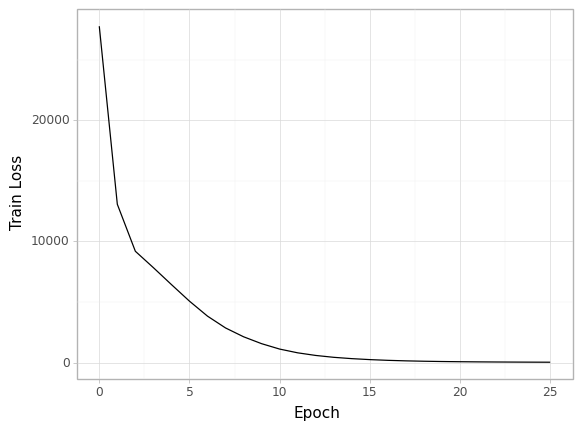

<ggplot: (8777285098954)>

In [473]:
( # 안 건드려도 될거 같음
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [474]:
# 안 건드려도 될거 같음
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

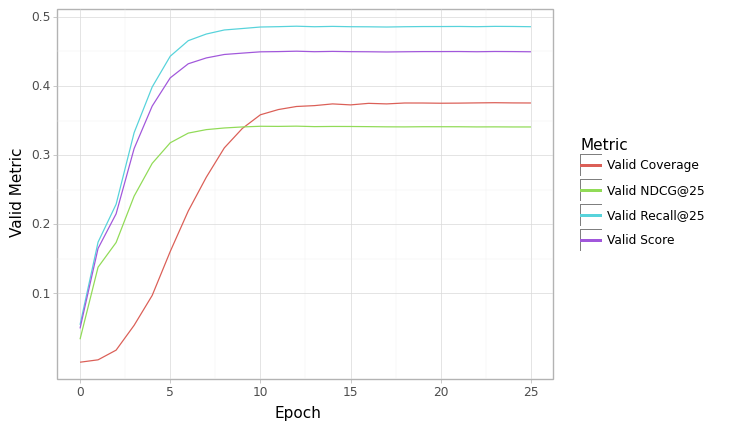

<ggplot: (8777283324615)>

In [475]:
( # 안 건드려도 될거 같음
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [476]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth'))) # 안 건드려도 될거 같음

<All keys matched successfully>

In [477]:
submission_path = os.path.join(data_path, 'sample_submission.csv') # 안 건드려도 될거 같음
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [478]:
submission.to_csv(os.path.join(output_path, 'submission.csv'), index = False) # 안 건드려도 될거 같음